## Import Libraries

In [21]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import count

In [22]:
spark = SparkSession \
        .builder \
        .appName("RestaurantRecommendation") \
        .getOrCreate()
sc = spark.sparkContext

## Read Data

In [23]:
data_path = '/Users/ashwinraghunath/Downloads/archive_3/'

business_dataframe = spark.read.json(data_path + 'yelp_academic_dataset_business.json')
reviews_dataframe  = spark.read.json(data_path + 'yelp_academic_dataset_review.json')
users_dataframe  = spark.read.json(data_path + 'yelp_academic_dataset_user.json')

In [24]:
print("Business Dataframe Schema:")
business_dataframe.printSchema()

print("Reviews Dataframe Schema:")
reviews_dataframe.printSchema()

print("Users Dataframe Schema:")
users_dataframe.printSchema()

Business Dataframe Schema:
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |

## Filter Restaurant businesses for Montreal

In [36]:
montreal_restaurants = business_dataframe.select('business_id', 'name',  'address', 'city',
                                          'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories') \
                                    .filter( ((business_dataframe.city == 'Montreal') | (business_dataframe.city == 'Montréal')) & (business_dataframe.categories.contains('Restaurants') ) )

print(f'Montreal Restaurants Count: {montreal_restaurants.count()}')

Montreal Restaurants Count: 4171
+--------------------+--------------------+--------------------+--------+-----+-----------+-------------+--------------+-----+------------+--------------------+
|         business_id|                name|             address|    city|state|postal_code|     latitude|     longitude|stars|review_count|          categories|
+--------------------+--------------------+--------------------+--------+-----+-----------+-------------+--------------+-----+------------+--------------------+
|LoRef3ChgZKbxUio-...|                Amir|5252 Rue Jean Tal...|Montréal|   QC|    H4P 2A7|45.4948701572|-73.6519035927|  3.0|          18|Restaurants, Leba...|
|6GHwgKNlvfIMUpFax...|L'Artisan Piadineria|3421 Rue Saint-Denis|Montréal|   QC|    H2L 3L2| 45.517368812|-73.5679399967|  4.0|           9|Sandwiches, Itali...|
+--------------------+--------------------+--------------------+--------+-----+-----------+-------------+--------------+-----+------------+--------------------+
o

# Extract restaurant reviews in Montreal, filtered by matching the restaurant IDs with the ones obtained in the previous step

In [37]:
montreal_restaurant_reviews = reviews_dataframe.join(montreal_restaurants, on = 'business_id', how = 'inner') \
                          .select(reviews_dataframe.business_id, reviews_dataframe.user_id, reviews_dataframe.review_id, reviews_dataframe.stars, reviews_dataframe.text)

print(f'Montreal Restaurants Reviews Count: {montreal_restaurant_reviews.count()}')
montreal_restaurant_reviews.show(2)

Montreal Restaurants Reviews Count: 139233
+--------------------+--------------------+--------------------+-----+--------------------+
|         business_id|             user_id|           review_id|stars|                text|
+--------------------+--------------------+--------------------+-----+--------------------+
|H464UiJ5c7q5dAJ14...|iDJCA-MMb8LRpBEN5...|rqGuZNdCcIVqqlmmj...|  4.0|Had a wonderful m...|
|LLOCKcFIKbeWmiyCG...|aFXA_ZCpPWhsHVg1U...|b9dq4-FW7DZPGvBcy...|  4.0|Huge breakfasts s...|
+--------------------+--------------------+--------------------+-----+--------------------+
only showing top 2 rows



# Filter users that have provided reviews to restaurants extracted

In [38]:
montreal_restaurant_users = users_dataframe.join(montreal_restaurant_reviews, on = 'user_id', how = 'inner') \
                          .select(users_dataframe.user_id, users_dataframe.name, users_dataframe.review_count, users_dataframe.yelping_since,
                                  users_dataframe.useful, users_dataframe.funny , users_dataframe.cool , users_dataframe.fans , users_dataframe.average_stars)


# Save sample files

In [28]:
montreal_restaurants.coalesce(1).write.parquet('Sample_Datasets/montreal_business')
montreal_restaurant_reviews.coalesce(1).write.parquet('Sample_Datasets/montreal_reviews')
montreal_restaurant_users.coalesce(1).write.parquet('Sample_Datasets/montreal_users')

# Data exploration

## What is the distribution of restaurant ratings in Montreal?

Text(0.5, 1.0, 'Distribution of restaurant ratings in Montreal')

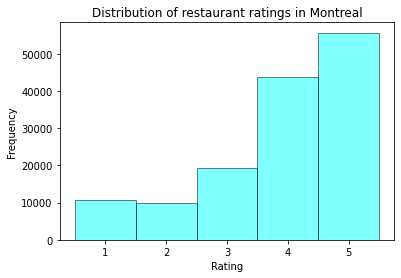

In [29]:
review_counts = montreal_restaurant_reviews.groupBy('stars').agg(count('*').alias('count'))
stars = [row[0] for row in review_counts.collect()]
counts = [row[1] for row in review_counts.collect()]

plt.hist(stars, weights=counts,
         bins=[0.5,1.5,2.5,3.5,4.5,5.5],
         alpha=0.5, histtype='barstacked',
         color='cyan',
         edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.title('Distribution of restaurant ratings in Montreal')

## What is the distribution of ratings of each restaurant in Montreal?

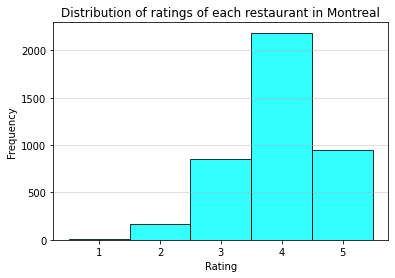

In [30]:
restaurant_reviews_counts = montreal_restaurants.groupBy('stars').agg(count('*').alias('count'))

stars = [row[0] for row in restaurant_reviews_counts.collect()]
counts = [row[1] for row in restaurant_reviews_counts.collect()]

plt.hist(stars, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], weights=counts, alpha=0.8,
histtype='barstacked', color='cyan', edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.title('Distribution of ratings of each restaurant in Montreal')

plt.grid(axis='y', alpha=0.5)
plt.show()